## Setup

In [72]:
import pandas as pd
from matplotlib_venn import venn2
from scipy.stats import hypergeom
from scipy.stats import norm
import math
import numpy as np
import seaborn as sns
import random as rn
import matplotlib.pyplot as plt

In [15]:
DATADIR= '~/Data/rat/data/final/'# location of input datasets
OUTDIR= '/cellar/users/snwright/Data/Transfer/rat/' # path to save intermediate and final datasets
ratThresh='relaxed'
num_reps=1000
#mapper='PASCAL'
#adj_type='bonf'
#rerun_analysis=False

## Import PCNet

In [2]:
import ndex2
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf'
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_PC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_PC.nodes)

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:', len(G_PC.nodes))
print('number of edges:', len(G_PC.edges))

number of nodes: 18820
number of edges: 2693250


In [5]:
pc_nodes = list(G_PC.nodes)

## Functions

In [74]:
def load_human_seed_genes(filepath, interactome_nodes, trait=''):
    """
    :param filepath:
    :param interactome_nodes:
    :param trait:
    """
    all_scores = pd.read_csv(filepath, sep="\t", index_col='gene_symbol')
    # subset to genes in the interactome
    all_scores = all_scores.loc[list(np.intersect1d(all_scores.index.tolist(), interactome_nodes))]
    # Calculate bonferroni corrected pvalue (alpha=0.05)
    bonf_p = .05/len(all_scores)
    # Get significant genes
    seeds = all_scores[all_scores['pvalue'] < bonf_p].index.tolist()
    print("Number of",trait,"seeds:", len(seeds))
    return seeds

def get_consensus_z_scores(sampled_results, percentile=.75):
    """
    returns the consensus z score for each gene across all samples
    :param sampled_results: output of netprop_zscore.calculate_heat_zscores_with_sampling
    :type sampled_results: str (file path) or pandas.DataFrame
    :param percentile: Percentile cut off for determining consensus score (default=0.75)
    :type percentile: float
    :return: Consensus z-scores for all genes based on sampling
    """
    if type(sampled_results) == str:
        results = pd.read_csv(sampled_results, sep="\t", index_col=0)
    else:
        results = sampled_results
    consensus_z = pd.DataFrame({'z': results.quantile(q=percentile, axis=1)})
    return consensus_z

def significance_of_gene_overlap(trait1, trait2, pc_nodes, seed_dict, plot=False):
    seeds1 = seed_dict[trait1]
    seeds2 = seed_dict[trait2]
    hyper = hypergeom(M=len(pc_nodes), n=len(seeds1), N=len(seeds2))
    intersect = set(seeds1).intersection(set(seeds2))
    p_intersect = hyper.sf(len(intersect))
    if plot:
        venn2([len(seeds1)-len(intersect), len(seeds2)-len(intersect), len(intersect)], [trait1, trait2], 
             set_colors=('purple', 'skyblue'), alpha=0.7)
    print("Overlapping genes:", len(intersect))
    print("P:", p_intersect)
    
    return len(intersect), p_intersect


def calculate_mean_z_score_distribution(trait1, trait2, num_reps, seed_dict, z_dict ,zero_double_negatives=False, 
                               overlap_control="remove"):
    """
    :param z1:
    :param z2:
    :param num_reps:
    :param zero_double_negatives:
    :param remove_seeds:
    :param seed1:
    :param seed2:
    """
    print("Estimated time:", num_reps * 2 / 100, "seconds")
    z1 = z_dict[trait1]
    z2 = z_dict[trait2]
    seed1 = seed_dict[trait1]
    seed2 = seed_dict[trait2]
    z1z2 = z1.join(z2, lsuffix="1", rsuffix="2")
    z1z2 = z1z2.assign(zz=z1z2.z1 * z1z2.z2)
    if overlap_control == "remove":
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    elif overlap_control == "bin":
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        overlap_z1z2 = z1z2.loc[seed_overlap]
        overlap_z1 = np.array(overlap_z1z2.z1)
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    z1 = np.array(z1z2.z1)
    z2 = np.array(z1z2.z2)
    if zero_double_negatives:
        for node in z1z2.index:
            if (z1z2.loc[node].z1 < 0 and z1z2.loc[node].z2 < 0):
                z1z2.loc[node, 'zz'] = 0
    permutation_means = np.zeros(num_reps)
    for i in range(num_reps):
        perm_z1z2 = np.zeros(len(z1))
        np.random.shuffle(z1)

        for node in range(len(z1)):
            if not zero_double_negatives or not (z1[node] < 0 and z2[node] < 0):
                perm_z1z2[node] = z1[node] * z2[node]
            else:
                perm_z1z2[node] = 0
        if overlap_control == "bin":
            overlap_perm_z1z2 = np.zeros(len(overlap_z1))
            np.random.shuffle(overlap_z1) 
            for node in range(len(overlap_z1)):
                if zero_double_negatives and (overlap_z1[node] < 0 and z2[node] < 0):
                    overlap_perm_z1z2[node] = 0
                else:
                    overlap_perm_z1z2[node] = overlap_z1[node] * z2[node]
            perm_z1z2 = np.concatenate([perm_z1z2, overlap_perm_z1z2])
                    
        
        permutation_means[i] = np.mean(perm_z1z2)
    return np.mean(z1z2.zz), permutation_means


def get_p_from_permutation_results(observed, permuted):
    """
    Calculates the significance of the observed mean relative to the empirical normal distribution of permuted means.
    :param observed: observed mean NPS_hr
    :param permuted: vector of means from permuted NPS_hr
    """
    p = norm.sf((observed-np.mean(permuted))/np.std(permuted))
    p = round(p, 4 - int(math.floor(math.log10(abs(p)))) - 1)
    return(p)


def calculate_expected_overlap(trait1, trait2, seed_dict, z_dict, 
                               z_score_threshold=3, z1_threshold=1.5,
                               z2_threshold=1.5,
                               num_reps=1000, plot=False, overlap_control=None):
    """
    Determines size of expected network overlap by randomly
    shuffling gene names

    :param z_scores_1: Result from :py:func:`~netcoloc.netprop_zscore.netprop_zscore`
                       or :py:func:`~netcoloc.netprop_zscore.calculate_heat_zscores`
                       containing the z-scores of each gene following network
                       propagation. The index consists of gene names
    :type z_scores_1: :py:class:`pandas.Series`
    :param z_scores_2: Similar to **z_scores_1**. This and **z_scores_1**
                       must contain the same genes (ie. come from the same
                       interactome network)
    :type z_scores_2: :py:class:`pandas.Series`
    :param z_score_threshold: threshold to determine whether a gene is
        a part of the network overlap or not. Genes with combined z-scores
        below this threshold will be discarded
    :type z_score_threshold: float
    :param z1_threshold: individual z1-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z1-scores
        below this threshold will be discarded
    :type z1_threshold: float
    :param z2_threshold: individual z2-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z2-scores
        below this threshold will be discarded
    :type z2_threshold: float
    :param num_reps:
    :param plot: If ``True``, distribution will be plotted
    :type plot: bool
    :return:
    :rtype: float
    """
    z_scores_1 = z_dict[trait1]
    z_scores_2 = z_dict[trait2]
    seed1 = seed_dict[trait1]
    seed2 = seed_dict[trait2]
    print("Estimated time:", num_reps * 2 / 100, "seconds")
    # Build a distribution of expected network overlap sizes by shuffling node names
    random_network_overlap_sizes = []
    if isinstance(z_scores_1, pd.DataFrame):
        z1z2 = z_scores_1.join(z_scores_2, lsuffix="1", rsuffix="2")
        z1z2 = z1z2.assign(zz=z1z2.z1 * z1z2.z2)
    elif isinstance(z_scores_1, pd.Series):
        z1z2 = pd.concat([z_scores_1, z_scores_2], axis=1)
    if overlap_control == "remove":
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    elif overlap_control == "bin":
        seed_overlap = list(set(seed1).intersection(set(seed2)))
        print("Overlap seed genes:", len(seed_overlap))
        overlap_z1z2 = z1z2.loc[seed_overlap]
        overlap_z1 = np.array(overlap_z1z2.z1)
        overlap_z2 = np.array(overlap_z1z2.z2)
        z1z2.drop(seed_overlap, axis=0, inplace=True)
    z1 = np.array(z1z2.z1)
    z2 = np.array(z1z2.z2)
    
    network_overlap_size = len(calculate_network_overlap(z1z2.z1, z1z2.z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
    network_overlap_size += len(calculate_network_overlap(overlap_z1z2.z1, overlap_z1z2.z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
    
    random_network_overlap_sizes = np.zeros(num_reps)
    for i in range(num_reps):
        perm_z1z2 = np.zeros(len(z1))
        rn.shuffle(z1)
        perm_size = len(calculate_network_overlap(z1, z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
        if overlap_control == "bin":
            overlap_perm_z1z2 = np.zeros(len(overlap_z1))
            rn.shuffle(overlap_z1) 
            perm_size_overlap = len(calculate_network_overlap(overlap_z1, overlap_z2,
                                                         z_score_threshold=z_score_threshold,
                                                         z1_threshold=z1_threshold,
                                                         z2_threshold=z2_threshold))
            
            perm_size += perm_size_overlap
                    
        
        random_network_overlap_sizes[i] = perm_size
    

    if plot:
        plt.figure(figsize=(5, 4))
        dfig = sns.histplot(random_network_overlap_sizes,
                            label='Expected network intersection size')
        plt.vlines(network_overlap_size, ymin=0, ymax=dfig.dataLim.bounds[3], color='r',
                   label='Observed network intersection size')
        plt.xlabel('Size of proximal subgraph, z > ' + str(z_score_threshold),
                   fontsize=16)
        plt.legend(fontsize=12)

    return network_overlap_size, random_network_overlap_sizes

 
    
def calculate_network_overlap(z_scores_1, z_scores_2, z_score_threshold=3,
                              z1_threshold=1.5, z2_threshold=1.5):
    """
    Function to determine which genes overlap. Returns a list of the
    overlapping genes

    :param z_scores_1: Result from :py:func:`~netcoloc.netprop_zscore.netprop_zscore`
                       or :py:func:`~netcoloc.netprop_zscore.calculate_heat_zscores`
                       containing the z-scores of each gene following network
                       propagation. The index consists of gene names
    :type z_scores_1: :py:class:`pandas.Series`
    :param z_scores_2: Similar to **z_scores_1**. This and **z_scores_1**
                       must contain the same genes (ie. come from the same
                       interactome network)
    :type z_scores_2: :py:class:`pandas.Series`
    :param z_score_threshold: threshold to determine whether a gene is
        a part of the network overlap or not. Genes with combined z-scores
        below this threshold will be discarded
    :type z_score_threshold: float
    :param z1_threshold: individual z1-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z1-scores
        below this threshold will be discarded
    :type z1_threshold: float
    :param z2_threshold: individual z2-score threshold to determine whether a gene is
        a part of the network overlap or not. Genes with z2-scores
        below this threshold will be discarded
    :type z2_threshold: float
    :return: genes in the network overlap (genes with high combined
            z-scores)
    :rtype: list
    """
    if isinstance(z_scores_1, pd.Series):
        z_scores_1 = z_scores_1.to_frame(name='z_scores_1')
        z_scores_2 = z_scores_2.to_frame(name='z_scores_2')
    elif isinstance(z_scores_1, np.ndarray):
        z_scores_1 = pd.DataFrame({"z_scores_1":z_scores_1})
        z_scores_2 = pd.DataFrame({"z_scores_2":z_scores_2})
    else:
        z_scores_1.columns = ["z_scores_1"]
        z_scores_2.columns = ["z_scores_2"]
    z_scores_joined = z_scores_1.join(z_scores_2)
    z_scores_combined = (z_scores_joined['z_scores_1']
                        * z_scores_joined['z_scores_2']
                        * (z_scores_joined['z_scores_1'] > 0)
                        * (z_scores_joined['z_scores_2'] > 0))
    # get rid of unlikely genes which have low scores in either z1 or z2
    high_z_score_genes = z_scores_combined[
        (z_scores_combined >= z_score_threshold)
         & (z_scores_joined['z_scores_1'] > z1_threshold)
         & (z_scores_joined['z_scores_2'] > z2_threshold)
    ].index.tolist()

    return high_z_score_genes


def plot_permutation_histogram(permuted, observed, title, xlabel):
    """
    Plot the observed mean of NPS_hr against a density histrogram of the means of permuted NPS_hr
    :param permuted: Vector of means of permuted NPS_hr
    :param observed: Observed mean of NPS_hr
    :param title: String for plot title
    :param xlabel: String for x-axis label
    """
    plt.figure(figsize=(5, 4))
    dfig = sns.histplot(permuted, label='Expected', alpha=0.4, stat='density', bins=25, kde=True, 
                        edgecolor='w')
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    plt.xlabel(xlabel, fontsize=16)
    diff = max(observed, max(permuted))-min(permuted)
    plt.arrow(x = observed, y=dfig.dataLim.bounds[3]/2, dx=0, dy = -1 * dfig.dataLim.bounds[3]/2,label = "Observed",
              width=diff/100, head_width=diff/15, head_length=dfig.dataLim.bounds[3]/20, overhang=0.5, 
              length_includes_head=True, color="red", zorder=50)
    #plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Density", fontsize=16)
    plt.legend(fontsize=12, loc=(0.6,0.75))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.locator_params(axis="y", nbins=6)
    plt.title(title+" (p="+str(get_p_from_permutation_results(observed, permuted))+")", fontsize=16)

## Define comparisons

In [ ]:
comparisons = [('rBMI', 'hBMI'), ("rBMI", "rBL")]

Could put the below functions in a loop structure to do a series of comparisons
```
for comp in comparisons:
    trait1 = comp[0]
    trait2 = comp[1]
    # <load seed genes for trait1 & 2> as seeds1, seeds2
    # <load labeled z_scores for trait1 & 2> as z1, z2
    seed_dict = {trait1: seeds1, trait1:seeds2}
    z_dict {trait1: z1, trait2: z2}
    # Direct overlap
    overlap, p_overlap = significance_of_gene_overlap(trait1, trait2, pc_nodes, seed_dict, plot=False)
    # Mean NPS
    observed_mean, permuted_means = calculate_mean_z_score_distribution(trait1, trait2, num_reps=1000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed_dict=seed_dict, z_dict=z_dict)
    p_mean = get_p_from_permutation_results(observed_mean, permuted_means)                                             
    # Network size
    observed_sz, permuted_sz = calculate_expected_overlap(trait1, trait2, seed_dict=seed_dict, z_dict=z_dict, 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin")
    p_value = get_p_from_permutation_results(observed_sz, permuted_sz)                                                         ```                

## In a loop

## Import Seed Genes

In [9]:
# if results have not already been subset to significant, otherwise just load
seed_bin_human_BMI = load_human_seed_genes(DATADIR+'GIANT_BMI_pascal.sum.genescores.txt', 
                                           pc_nodes, 'BMI')

Number of BMI seeds: 1958


In [19]:
seed_bin_rat_BMI=pd.read_csv(DATADIR+'ratBMI_seed_'+ratThresh+'.txt',sep='\t')['0'].tolist()
seed_bin_rat_BL=pd.read_csv(DATADIR+'ratBL_seed_'+ratThresh+'.txt',sep='\t')['0'].tolist()

In [20]:
# put into dictionary for ease of access. 
seed_dict = {'hBMI':seed_bin_human_BMI,
             'rBMI':seed_bin_rat_BMI, 'rBL':seed_bin_rat_BL}

## Import Z-scores

In [21]:
# if consensus has not been previously calculated, otherwise just load
z_human_bin_BMI =get_consensus_z_scores(DATADIR+'z_human_bin_BMI_SAMPLED_500_100_weighted.tsv')

In [22]:
out_name = 'rat_BMI_'+ratThresh
z_rat_BMI=pd.read_csv(DATADIR+'z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                          index_col='gene',names=['gene','z'], header=0)
out_name = 'rat_BL_'+ratThresh
z_rat_BL=pd.read_csv(DATADIR + 'z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                         index_col='gene', names=['gene', 'z'], header=0)

In [23]:
z_dict = {'hBMI':z_human_bin_BMI,
          'rBMI':z_rat_BMI,'rBL':z_rat_BL}

In [37]:
# Each z series should look like this for functions to work properly
z_dict['hBMI']

,z
UBE2Q1,-0.059048
RNF14,-0.413490
UBE2Q2,-0.090295
TMCO1,-0.319948
UBAC1,1.268305
...,...
CD300LD,0.397138
SLC10A5,-0.270149
BAGE4,0.301993
FAM181B,2.324852


## Significance of gene overlap

Overlapping genes: 29
P: 0.5813676573237017


(29, 0.5813676573237017)

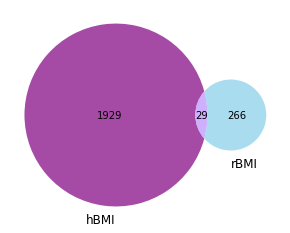

In [35]:
significance_of_gene_overlap('hBMI', 'rBMI', pc_nodes, seed_dict, plot=True)

Overlapping genes: 25
P: 2.4520867473107065e-11


(25, 2.4520867473107065e-11)

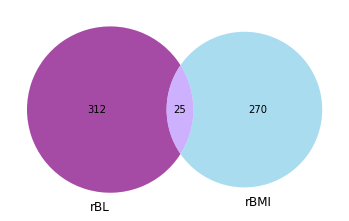

In [39]:
significance_of_gene_overlap('rBL', 'rBMI', pc_nodes, seed_dict, plot=True)

## Significance of mean NPS

Estimated time: 20.0 seconds
Overlap seed genes: 29


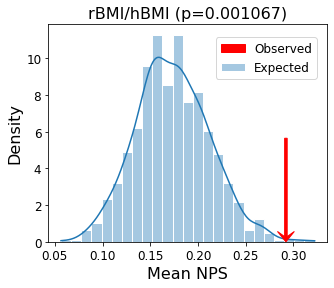

In [76]:
observed_mean, permuted_means = calculate_mean_z_score_distribution('rBMI', 'hBMI', num_reps=1000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed_dict=seed_dict, z_dict=z_dict)
plot_permutation_histogram(observed=observed_mean,permuted=permuted_means, title='rBMI/hBMI', xlabel='Mean NPS' )

In [56]:
p_value = get_p_from_permutation_results(observed_mean, permuted_means)
print(p_value)

0.001242


Estimated time: 20.0 seconds
Overlap seed genes: 25


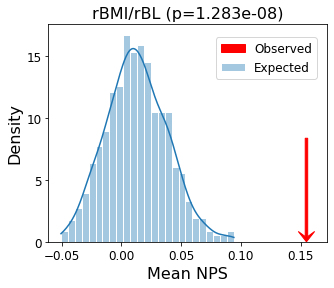

In [77]:
observed_mean, permuted_means = calculate_mean_z_score_distribution('rBMI', 'rBL', num_reps=1000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed_dict=seed_dict, z_dict=z_dict)
plot_permutation_histogram(observed=observed_mean,permuted=permuted_means, title='rBMI/rBL', xlabel='Mean NPS' )

In [58]:
p_value = get_p_from_permutation_results(observed_mean, permuted_means)
print(p_value)

1.298e-08


## Significance of network size

Estimated time: 20.0 seconds
Overlap seed genes: 29


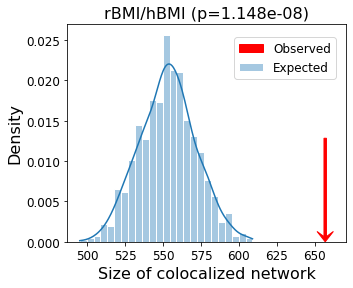

In [78]:
observed_sz, permuted_sz = calculate_expected_overlap('rBMI', 'hBMI', seed_dict=seed_dict, z_dict=z_dict, 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin")
plot_permutation_histogram(observed=observed_sz,permuted=permuted_sz, title='rBMI/hBMI', xlabel='Size of colocalized network' )

In [79]:
p_value = get_p_from_permutation_results(observed_sz, permuted_sz)
print(p_value)

1.148e-08


Estimated time: 20.0 seconds
Overlap seed genes: 25


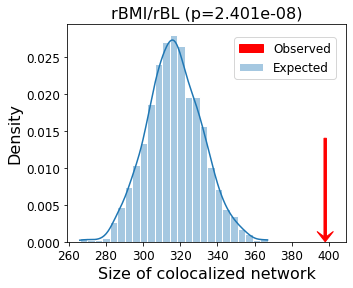

In [80]:
observed_sz, permuted_sz = calculate_expected_overlap('rBMI', 'rBL', seed_dict=seed_dict, z_dict=z_dict, 
                                                                      z_score_threshold=3, z1_threshold=1.0,
                                                                      z2_threshold=1.0, num_reps=1000, plot=False, 
                                                                              overlap_control="bin")
plot_permutation_histogram(observed=observed_sz,permuted=permuted_sz, title='rBMI/rBL', xlabel='Size of colocalized network' )

In [81]:
p_value = get_p_from_permutation_results(observed_sz, permuted_sz)
print(p_value)

2.401e-08
